# Mean Variance Frontier w/w.o Short Sales Constraints

This code below calculates mean variances frontiers (a) when there are no restrictions on the portfolio weights and (b) when we impose the restriction that no weights can be negative.

The latter case requires a numerical minimization routine (the code uses quadprog), which comes from the packages MathProgBase and Ipopt.

# Load Packages

In [1]:
using Dates, MathProgBase, Ipopt        

include("printmat.jl")    

printlnPs (generic function with 2 methods)

In [3]:
using Plots
backend = "gr"              #"gr" (default), "pyplot" 

if backend == "pyplot"
    pyplot(size=(600,400))
else    
    gr(size=(480,320))
    default(fmt = :svg)
end

# Traditional MV Calculations (no constraints)

In [4]:
μ = [0.115; 0.095; 0.06]    #expected returns
Σ  = [166  34  58;          #covariance matrix
       34  64   4;
       58   4 100]/100^2                  
Rf = 0.03

println("μ, Σ and Rf: ")
printmat(μ)
printmat(Σ)
printlnPs(Rf)

μ, Σ and Rf: 
     0.115
     0.095
     0.060

     0.017     0.003     0.006
     0.003     0.006     0.000
     0.006     0.000     0.010

     0.030


## From Ch3 Notebook (MV Frontier without portfolio constraints)

In [5]:
function MVCalc(mustar,μ,Σ)           #calculates the std of a portfolio on MVF
    n    = length(μ)
    oneV = ones(n) 
    Σ_1  = inv(Σ)
    A    = μ'Σ_1*μ
    B    = μ'Σ_1*oneV
    C    = oneV'Σ_1*oneV
    λ    = (C*mustar - B)/(A*C-B^2)
    δ    = (A-B*mustar)/(A*C-B^2)
    w    = Σ_1 *(μ*λ + oneV*δ)
    StdRp = sqrt(w'Σ*w)
    return StdRp,w
end

MVCalc (generic function with 1 method)

In [6]:
mustar = range(0.04,stop=0.15,length=101)      #0.7 syntax
L      = length(mustar)
StdRp  = fill(NaN,L)
for i = 1:L
    StdRp[i] = MVCalc(mustar[i],μ,Σ)[1]
end    

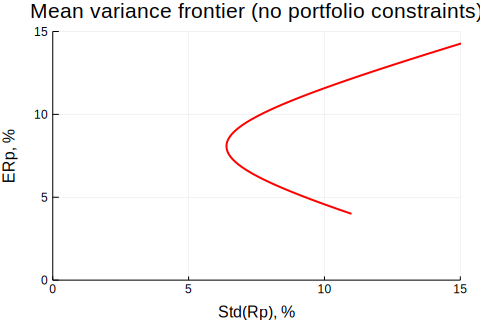

In [7]:
p1 = plot(StdRp*100,mustar*100,color=:red,linewidth=2,legend=false)
plot!(xlim=(0,15),ylim=(0,15))
title!("Mean variance frontier (no portfolio constraints)")
xlabel!("Std(Rp), %")
ylabel!("ERp, %")

# MV Frontier when Short Sales are Not Allowed

The code below solves (numerically) the following minimization problem 

$\min \text{Var}(R_p) \: \text{ s.t. } \: \text{E}R_p = \mu^*$,
 
and where we require $w_i\ge 0$.
 
The code below calls on
```
quadprog(zeros(N),Sigma,A,'=',b,zeros(N),ones(N),IpoptSolver(print_level=1))
```

This means that we minimize
$0'w + w' \Sigma w/2$ subject to the constraints $A w = b$ and $0 \leq w \leq 1$. The equality constraints ($A w = b$) are used to impose $1'w=1$ and $\mu'w = \mu^*$ (se the code below).
    
The ```quadprog()``` function is tailor made for linear-quadratic optimization problems with constraints. More general optimization functions would also work, but are likely to be slower.

In [8]:
function MeanVarNoSSPs(mu,Sigma,mustar)   #MV with no short-sales, numerical minimization
    (w_p,StdRp) = (NaN,NaN)               #default result (if no feasible solution)        
    N = length(mu)
    if minimum(mu) <= mustar <= maximum(mu)  #try only if feasible
        A   = [ones(1,N);mu']                #1'w=1, mu'w = mustar
        b   = [1;mustar]
        Sol = quadprog(zeros(N),Sigma,A,'=',b,zeros(N),ones(N),IpoptSolver(print_level=1))
        if Sol.status == :Optimal
            w_p = Sol.sol
            StdRp = sqrt(w_p'Sigma*w_p)
        end    
    end    
    return StdRp,w_p
end

MeanVarNoSSPs (generic function with 1 method)

In [9]:
Std_no_ss = fill(NaN,length(mustar))
for i = 1:length(mustar)
    Std_no_ss[i] = MeanVarNoSSPs(μ,Σ,mustar[i])[1]     #[1] to get first output
end


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



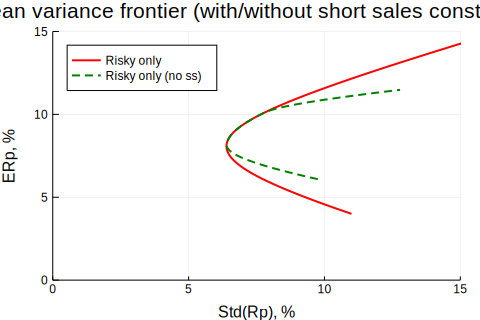

In [10]:
p1 = plot(StdRp*100,mustar*100,color=:red,linewidth=2,label="Risky only")
plot!(Std_no_ss*100,mustar*100,color=:green,line=(:dash,2),label="Risky only (no ss)  ")
plot!(xlim=(0,15),ylim=(0,15),legend=:topleft)
title!("Mean variance frontier (with/without short sales constraints)")
xlabel!("Std(Rp), %")
ylabel!("ERp, %")